File count: 8
image size =  (2330, 3492)


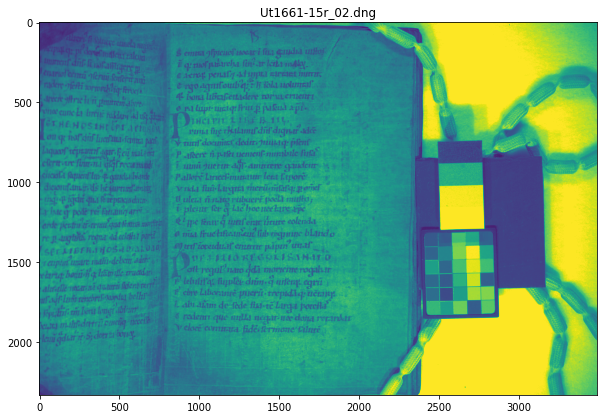

0


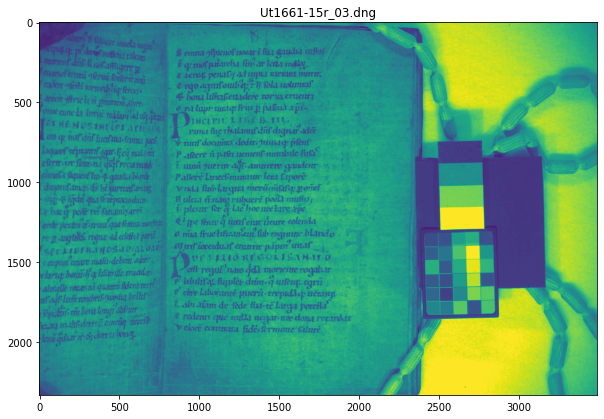

1


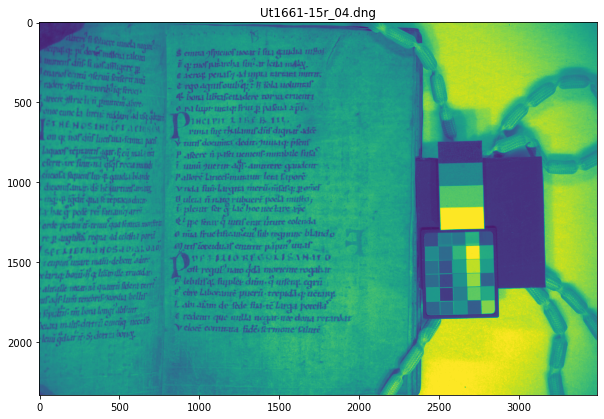

2


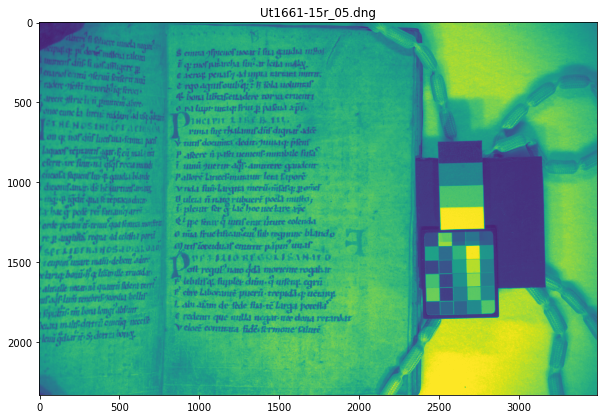

3


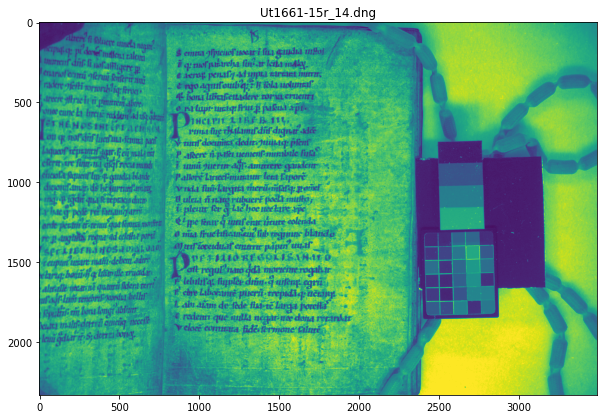

4


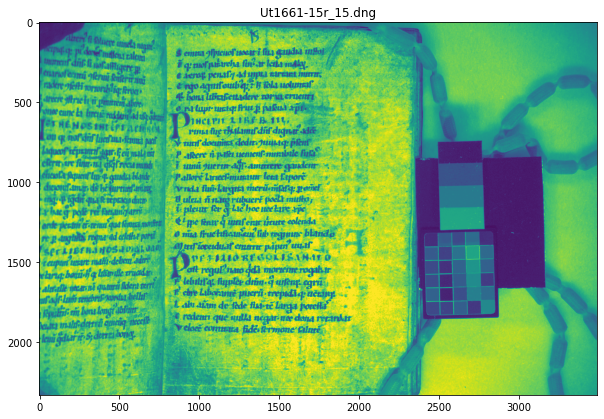

5


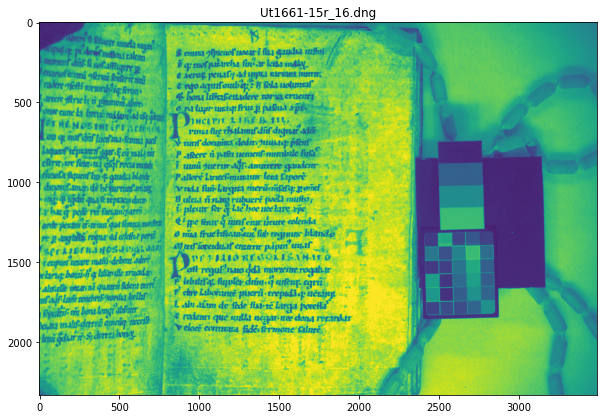

6


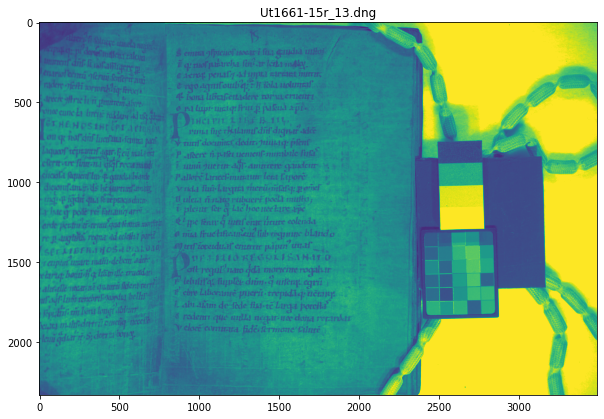

7


In [1]:
# Import packages
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from scipy.ndimage import zoom
import rawpy
import numpy

# Folder path where all inputs and outputs are located
dir_path = r'INSERT_FOLDER_PATH_HERE'
# Place the RAW files in a folder called RAW_files, or change the name of the folder here.
im_path = dir_path + 'RAW_files/'


# This counts the amount of files in the RAW directory
n_bands = 0
# Iterate directory
for path in os.listdir(im_path):
    n_bands += 1
print('File count:', n_bands)
path = im_path + str(os.listdir(im_path)[0])

# The zoom-factor is how much the files are zoomed out, to save RAM.
zoom_factor = 0.5

# Open the first RAW file to probe the size of the files. If preferred, a mask can be applied to only process part
# of the image, again saving RAM.
img = zoom(rawpy.imread(path).postprocess(),zoom_factor)

# Determine the shape of the images
img_shape = img.shape[:2]
print('image size = ',img_shape)
img = 0

# 3 dimensional dummy array with zeros where the images will be loaded into
MB_img = np.zeros((img_shape[0],img_shape[1],n_bands))

# Stacking up images into the array
for i in range(n_bands):
    
    # If a mask was applied to the image, it should also be applied here
    temp_image = rawpy.imread(im_path + os.listdir(im_path)[i]).postprocess()
    
    # If the RAW files are RGB, you have to uncomment the line below and comment the line below that
    #MB_img[:,:,i] = zoom(.299*temp_image[:,:,0] + 0.587*temp_image[:,:,1] + 0.114*temp_image[:,:,2], zoom_factor)
    MB_img[:,:,i] = zoom(temp_image[:,:,0],zoom_factor)
    
    # If this line is uncommented, the zoomed-in RAW is saved as a PNG
    #plt.imsave(fname= str(i), arr= temp, cmap='viridis', format='png')
    
    # Show the images that are loaded into the array to help selecting them
    plt.figure(figsize = (10,10))
    plt.title(os.listdir(im_path)[i])
    plt.imshow(MB_img[:,:,i])
    plt.show()
    print(i)

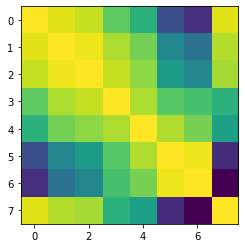

Eigenvalues:

 [6.50961165e+00 1.31390880e+00 9.53474459e-02 3.20327888e-02
 2.27473586e-02 5.25970288e-03 6.36562498e-03 1.47276115e-02] 



In [2]:
MB_matrix = np.zeros((MB_img[:,:,0].size,n_bands))

# This converts the 3d array into a 2d one
for i in range(n_bands):
    MB_array = MB_img[:,:,i].flatten()
    MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()  
    MB_matrix[:,i] = MB_arrayStd

# Save some RAM by overwriting some big variables
MB_img = 0
temp_image = 0

# Calculate the covariance matrix
cov = np.cov(MB_matrix.transpose())

# Calculate the Eigenvectors
EigVal,EigVec = np.linalg.eig(cov)
# Show the covariance matrix, which is helpfull to select images to remove
plt.imshow(cov)
plt.show()

# Print the eigenvalues
print("Eigenvalues:\n\n", EigVal,"\n")


In [3]:
# Projecting data on Eigen vector directions resulting to Principal Components
PC = np.matmul(MB_matrix,EigVec)   #cross product

PC_2d = np.zeros((img_shape[0],img_shape[1],n_bands))

# Make the PC's into 2d arrays
for i in range(n_bands):
    PC_2d[:,:,i] = PC[:,i].reshape(-1,img_shape[1])

# normalizing between 0 to 255
PC_2d_Norm = np.zeros((img_shape[0],img_shape[1],n_bands))
for i in range(n_bands):
    PC_2d_Norm[:,:,i] = cv2.normalize(PC_2d[:,:,i],
                        np.zeros(img_shape),0,255 ,cv2.NORM_MINMAX)
    
# Save the results in the folder as PNG's
for i in range(n_bands):
    plt.imsave(fname=dir_path + "/PC"+ str(i)+".png", arr=PC_2d_Norm[:,:,i], cmap='viridis_r', format='png')
    plt.close()
